## Import and install dependencies

In [2]:
!pip install PyPDF2
!pip install scikit-network
!pip install python-dotenv

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

import os
import spacy
import requests
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse as sp
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from calendar import monthrange
from IPython.display import SVG
from sknetwork.data import Bunch
from sknetwork.ranking import PageRank
from sknetwork.visualization import svg_graph
from networkx.algorithms.community import greedy_modularity_communities

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 34.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


## Using **The Guardian** API to Search for Recent Articles Related to a Subject (e.g., Bitcoin)

The /search endpoint allows you to query articles with optional filters such as `tag` and `section` to refine your results.

By default, you can use the **"test"** API key provided by The Guardian for experimentation and basic queries. However, if you plan to use this API for a project, it is highly recommended to sign up for your own API key to benefit from higher request limits and additional features.  

Visit [The Guardian Developer website](https://open-platform.theguardian.com/) and register for a free API key.

For more details on how to use this API effectively, refer to the [official documentation](https://open-platform.theguardian.com/documentation/).


### Search for tags associated with a given term using **The Guardian** API.  

In [4]:
def search_tags(term, api_key="test"):
    """
    Search for tags related to a specific term using The Guardian API.

    Parameters:
        term (str): The term to search for.
        api_key (str): The API key for The Guardian API. Defaults to "test".

    Returns:
        list: A list of tag IDs related to the term, or None if an error occurs.
    """
    base_url = "https://content.guardianapis.com/tags"
    params = {
        "q": term,
        "api-key": api_key
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()

        tags_data = response.json()
        if tags_data:
            return [tag["id"] for tag in tags_data["response"]["results"]]

        return []
    except requests.exceptions.RequestException as e:
        print(f"Error fetching tags: {e}")
        return None


### Fetch the Latest Article URLs from **The Guardian** API based on a search term (`query`)



In [5]:
def get_latest_guardian_articles_urls(query, api_key="test", page_size=10, tag=None, section=None):
    """
    Fetch the latest article URLs related to a specific query from The Guardian API.

    Parameters:
        query (str): The term to search for.
        api_key (str): The API key for The Guardian API. Defaults to "test".
        page_size (int): Number of articles to return. Defaults to 10.
        tag (str, optional): A tag to filter results (e.g., "technology/bitcoin").
        section (str, optional): A section to filter results (e.g., "economy").

    Returns:
        list: A list of article URLs, or None if an error occurs.
    """
    base_url = "https://content.guardianapis.com/search"

    params = {}

    if section:
      params["section"] = section
      #print(f"Using section: {section}")

    if tag:
      params["tag"] = tag
      #print(f"Using tag: {tag}")

    params["order-by"] = "newest"
    params["page-size"] = page_size
    params["q"] = query
    params["api-key"] = api_key

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()

        print(f"Request URL: {response.url}")

        articles_data = response.json()
        if articles_data and articles_data['response']['results']:
            return [article["webUrl"] for article in articles_data['response']['results']]

        print("No articles found.")
        return []
    except requests.exceptions.RequestException as e:
        print(f"Error fetching articles: {e}")
        return None


### Fetch the most relevante Article URLs from **The Guardian** API based on a search term (`query`) and a year



In [6]:
def get_guardian_articles_urls_by_year(query, year, api_key="test", page_size=10, tag=None, section=None):
    """
    Fetch the most relevant article URLs for a specific query from The Guardian API within a given year.

    Parameters:
        query (str): The term to search for.
        year (int): The year to filter results.
        api_key (str): The API key for The Guardian API. Defaults to "test".
        page_size (int): Number of articles to return per page. Defaults to 10.
        tag (str, optional): A tag to filter results (e.g., "technology/bitcoin").
        section (str, optional): A section to filter results (e.g., "economy").

    Returns:
        list: A list of article URLs, or None if an error occurs.
    """
    base_url = "https://content.guardianapis.com/search"

    # Define the date range for the entire year
    from_date = f"{year}-01-01"
    to_date = f"{year}-12-31"

    params = {}

    if section:
      params["section"] = section
      #print(f"Using section: {section}")

    if tag:
      params["tag"] = tag
      #print(f"Using tag: {tag}")

    params["from-date"] = from_date
    params["to-date"] = to_date
    params["order-by"] = "newest"
    params["page-size"] = page_size
    params["q"] = query
    params["api-key"] = api_key

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()

        print(f"Request URL: {response.url}")

        articles_data = response.json()
        if articles_data and articles_data['response']['results']:
            return [article["webUrl"] for article in articles_data['response']['results']]

        print("No articles found.")
        return []
    except requests.exceptions.RequestException as e:
        print(f"Error fetching articles: {e}")
        return None


## Using **NewsAPI** to Search for Articles Related to a Subject (e.g., Bitcoin)

The `/everything` endpoint of NewsAPI allows you to query articles with filters like `language`, `sortBy`, and `pageSize` to refine your results. You will need to get a **free API key**.

Visit [NewsAPI's website](https://newsapi.org/) to register for a free API key.

For detailed documentation, visit the [official NewsAPI documentation](https://newsapi.org/docs/endpoints/everything).


In [7]:
def get_newsapi_articles_urls_by_year(query, api_key, language="en", page_size=10):
    """
    Fetch the latest article URLs related to a specific query from NewsAPI.

    Parâmetros:
        query (str): The term to search for
        api_key (str): Chave de API para autenticação na NewsAPI.
        language (str): Idioma das notícias (padrão: "en").
        page_size (int): Número de artigos a retornar (máx. 100).

    Retorna:
        list: Lista de URLs de artigos sobre Bitcoin.
    """
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": query,
        "language": language,
        "pageSize": page_size,
        "sortBy": "relevancy",
        "apiKey": api_key
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()

        print(f"Request URL: {response.url}")

        data = response.json()

        if "articles" in data:
          return [article["url"] for article in data["articles"]]
        else:
          print("No articles found.")
          return []

    except requests.exceptions.RequestException as e:
        print(f"Error fetching articles: {e}")
        return []


## Using spaCy and Natural Language Toolkit (NLTK) to Process Articles from HTML Pages

This section demonstrates how to use **spaCy** and **NLTK** to process and analyze the content of articles retrieved using **The Guardian API**.  

#### Overview:

1. Text Extraction: parse the HTML obtained from The Guardian API URLs to extract the main article text.
2. Natural Language Processing (NLP):
   - **spaCy** used for tokenization, named entity recognition (NER), and part-of-speech (POS) tagging.
   - **NLTK** used for part-of-speech (POS) tagging.

### HTML parse and cleaning text article from given a given URL

In [8]:
def get_article_text(url):
    """
    Fetches and extracts the article text from a given URL.

    Parameters:
        url (str): The URL of the article to extract text from.

    Returns:
        str: The text content of the article, or None if an error occurs.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises an HTTPError for bad responses (4xx, 5xx)

        soup = BeautifulSoup(response.text, 'html.parser')

        # Only match <article> tag to get the main content
        article = soup.find('article')
        if not article:
            print(f"No <article> tag found for URL: {url}")
            return None

        # Find all relevant text elements (<p> for paragraphs, <h1>-<h6> for headings)
        tags = article.find_all(['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'])

        # Extract text and join it into a single string
        text = ''.join(tag.get_text(strip=True).rstrip('.\n') + ".\n" for tag in tags)

        return text

    except requests.exceptions.RequestException as e:
        print(f"Error processing URL {url}: {e}")
        return None

### Using only spaCy for tokenization, named entity recognition (NER), and part-of-speech (POS) tagging.

In [9]:
def process_text_with_spacy(text):
    """
    Processes the given text using spaCy for tokenization, part-of-speech tagging,
    and named entity recognition (NER).

    Parameters:
        text (str): The text to process.

    Returns:
        tuple: A tuple containing two elements:
            - A list of proper noun tags (tokens with tag 'NNP').
            - A list of filtered named entities (PERSON, ORG, GPE).
    """
    doc = nlp(text)

    sentences = list(doc.sents)

    entities = []
    nnp_tags = []

    for sentence in sentences:

      for token in sentence:
        if token.tag_ == 'NNP' and token.text.isalpha():
          nnp_tags.append(token.text)

      sentence_entities = []

      sent_doc = nlp(sentence.text)
      for ent in sent_doc.ents:
        if ent.label_ in ['PERSON', 'ORG', 'GPE']:
          entity = ent.text.strip().lower()

          if "'s" in entity:

              cutoff = entity.index("'s")

              entity = entity[:cutoff]

          if entity != '':

              sentence_entities.append(entity)

        sentence_entities = list(set(sentence_entities))

        if len(sentence_entities) > 1:

            entities.append(sentence_entities)

    return nnp_tags, entities

### Using spaCy and NLTK for tokenization, named entity recognition (NER), and part-of-speech (POS) tagging.

In [10]:
def process_text_with_nltk_and_spacy(text):
    """
    Process the given text using both NLTK and spaCy for tokenization,
    part-of-speech tagging, and named entity recognition (NER).

    Parameters:
        text (str): The text to be processed.

    Returns:
        tuple: A tuple containing:
            - A list of proper nouns (NNP) from POS tagging using NLTK.
            - A list of filtered named entities (PERSON, ORG, GPE) using spaCy.
    """
    try:
        #NLTK
        sentences = nltk.sent_tokenize(text)

        pos_tags = []
        for sentence in sentences:
            words = nltk.word_tokenize(sentence)
            pos_tags.extend(nltk.pos_tag(words))

        nnp_tags = [tag for tag in pos_tags if tag[1] == 'NNP' and tag[0].isalpha()]

        #spaCy
        doc = nlp(text)

        sentences = list(doc.sents)

        entities = []

        for sentence in sentences:
          sentence_entities = []

          sent_doc = nlp(sentence.text)
          for ent in sent_doc.ents:
            if ent.label_ in ['PERSON', 'ORG', 'GPE']:
              entity = ent.text.strip()

              if "'s" in entity:

                  cutoff = entity.index("'s")

                  entity = entity[:cutoff]

              if entity != '':

                  sentence_entities.append(entity)

            sentence_entities = list(set(sentence_entities))

            if len(sentence_entities) > 1:

                entities.append(sentence_entities)

        return nnp_tags, entities

    except Exception as e:
        print(f"Error processing text: {e}")
        return [], []


## Converting entities into network data


### Extract entities from articles_urls texts

In [11]:
def extract_entities(articles_urls, print_all=False):
    """
    Extracts named entities related to theme from a list of article URLs.

    Parameters:
        articles_urls (list of str): List of URLs to process.
        print_all (bool): If True, prints URLs, entities and NNP Tags.

    Returns:
        list: A list of named entities extracted from the articles.
    """
    entities = []

    for url in articles_urls:
        text = get_article_text(url)

        if print_all:
            print(f"URL: {url}")

        if text:
            #nnp_tags, article_entities = process_text_with_nltk_and_spacy(text)
            nnp_tags, article_entities = process_text_with_spacy(text)
            entities.extend(article_entities)

            if print_all:
                print("NNP Tags (Proper Nouns):", nnp_tags)
                print(f"Filtered Named Entities (PERSON, ORG, GPE): {article_entities}\n")

    return entities

### Get network data from entities

In [12]:
def get_network_data(entities):

    final_sources = []
    final_targets = []

    for row in entities:

        source = row[0]
        targets = row[1:]

        for target in targets:

            final_sources.append(source)
            final_targets.append(target)

    df = pd.DataFrame({'source':final_sources, 'target':final_targets})

    return df

## Draw networkx graphs from network data

In [13]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5, file_path=None):

    adjacency = nx.adjacency_matrix(G, weight='weight')
    adjacency = sp.csr_matrix(adjacency)

    names = np.array(list(G.nodes()))

    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)

    pagerank = PageRank()

    pagerank.fit(adjacency)
    scores = pagerank.scores_

    if show_names:

        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)

    else:

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)

    if file_path:
        with open(file_path, 'w') as f:
            f.write(image)

    return SVG(image)

In [14]:
def draw_ego_graph(G, ego, center=True, k=0, show_names=True, edge_width=0.1, node_size=3, font_size=12, file_path=None):

    G.remove_edges_from(nx.selfloop_edges(G))

    ego = nx.ego_graph(G, ego, center=center)

    ego = nx.k_core(ego, k)

    return draw_graph(ego, node_size=node_size, font_size=font_size, show_names=show_names, edge_width=edge_width, file_path=file_path)

## Configure environment, set query and apply functions to get graph and metrics

### Using the 100 newest articles from The Guardian api

In [15]:
nlp = spacy.load("en_core_web_sm")

load_dotenv()

api_key = os.getenv("THE_GUARDIAN_API_KEY", "test")

query = "bitcoin"

tag = search_tags(query, api_key)[0]

In [16]:
the_guardian_articles_urls = get_latest_guardian_articles_urls(query, api_key, page_size=100, tag=tag, section=None)

print(f"Número de artigos utilizados: {len(the_guardian_articles_urls)}")

Request URL: https://content.guardianapis.com/search?tag=technology%2Fbitcoin&order-by=newest&page-size=100&q=bitcoin&api-key=test
Número de artigos utilizados: 100


In [17]:
the_guardian_bitcoin_entities = extract_entities(the_guardian_articles_urls, print_all=False)

In [18]:
the_guardian_bitcoin_network_df = get_network_data(the_guardian_bitcoin_entities)

G_the_guardian_bitcoin = nx.from_pandas_edgelist(the_guardian_bitcoin_network_df)

G_the_guardian_bitcoin.remove_edges_from(nx.selfloop_edges(G_the_guardian_bitcoin))

In [19]:
print(G_the_guardian_bitcoin)
print(tag)

Graph with 1177 nodes and 1707 edges
technology/bitcoin


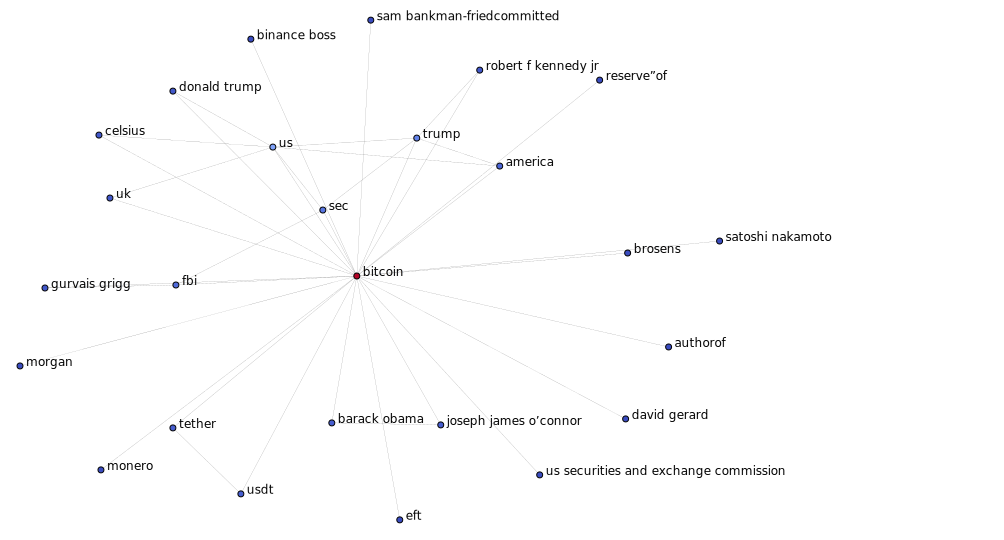

In [20]:
draw_ego_graph(G_the_guardian_bitcoin, 'bitcoin', file_path="latest_ego_bitcoin_graph.svg")

### Comparing graph using the most relevant articles of a year (2018) from The Guardian api

In [21]:
the_guardian_2018_bitcoin_articles_url = get_guardian_articles_urls_by_year(query, 2018, api_key, page_size=100, tag=tag, section=None)

print(f"Número de artigos utilizados: {len(the_guardian_2018_bitcoin_articles_url)}")

Request URL: https://content.guardianapis.com/search?tag=technology%2Fbitcoin&from-date=2018-01-01&to-date=2018-12-31&order-by=newest&page-size=100&q=bitcoin&api-key=test
Número de artigos utilizados: 72


In [22]:
the_guardian_2018_bitcoin_entities = extract_entities(the_guardian_2018_bitcoin_articles_url, print_all=False)

In [23]:
the_guardian_2018_bitcoin_network_df = get_network_data(the_guardian_2018_bitcoin_entities)

G_the_guardian_2018_bitcoin = nx.from_pandas_edgelist(the_guardian_2018_bitcoin_network_df)

G_the_guardian_2018_bitcoin.remove_edges_from(nx.selfloop_edges(G_the_guardian_2018_bitcoin))

In [24]:
print(G_the_guardian_2018_bitcoin)

Graph with 579 nodes and 592 edges


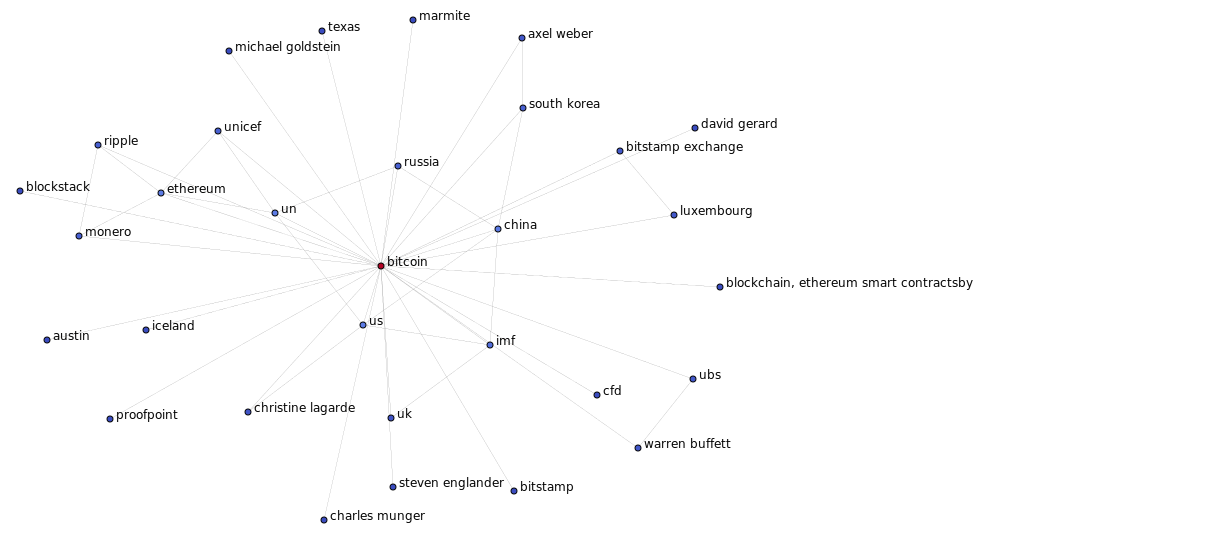

In [25]:
draw_ego_graph(G_the_guardian_2018_bitcoin, 'bitcoin', file_path="2018_ego_bitcoin_graph.svg")

### Last 200 articles about Bitcoin from The Guardian api

In [26]:
urls = get_latest_guardian_articles_urls(query, api_key, page_size=200, tag=tag)

print(f"Número de artigos utilizados: {len(urls)}")

Request URL: https://content.guardianapis.com/search?tag=technology%2Fbitcoin&order-by=newest&page-size=200&q=bitcoin&api-key=test
Número de artigos utilizados: 200


In [27]:
bitcoin_entities = extract_entities(urls, print_all=False)

In [28]:
bitcoin_network_df = get_network_data(bitcoin_entities)

G_bitcoin = nx.from_pandas_edgelist(bitcoin_network_df)

G_bitcoin.remove_edges_from(nx.selfloop_edges(G_bitcoin))

In [29]:
print(G_bitcoin)

Graph with 2064 nodes and 2986 edges


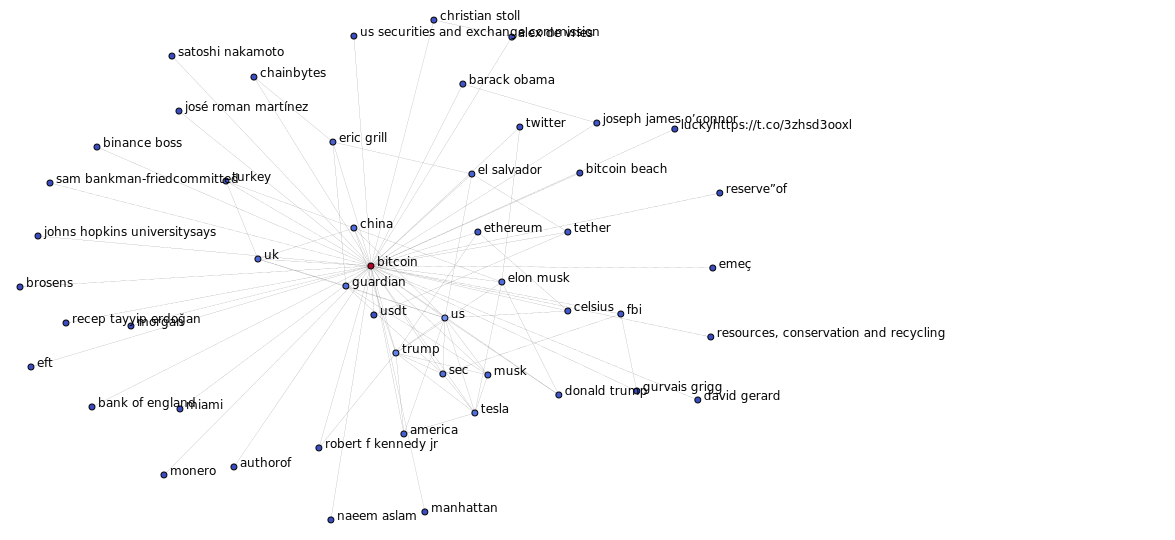

In [30]:
draw_ego_graph(G_bitcoin, 'bitcoin', file_path="last_200_articles_bitcoin_graph.svg")

## Exporting graphs to use in Gephi

In [34]:
import networkx as nx

def analyze_and_export_graph(graph, output_filename):
    """
    Perform centrality analysis, k-core/k-shell decomposition, and export the graph.

    Parameters:
    graph (networkx.Graph): The input graph to analyze.
    output_filename (str): The name of the output GEXF file.

    Returns:
    None
    """
    # Create a copy of the graph to work on
    graph = graph.copy()

    # Reassign node IDs to sequential integers from 0 to n-1
    mapping = {node: i for i, node in enumerate(graph.nodes())}
    reverse_mapping = {i: node for node, i in mapping.items()}
    graph = nx.relabel_nodes(graph, mapping)

    # Update node attributes for Gephi compatibility
    for node in graph.nodes():
        original_name = reverse_mapping[node]
        graph.nodes[node]["id"] = node
        graph.nodes[node]["name"] = original_name  # Original node name
        graph.nodes[node]["label"] = str(original_name)  # Unique identifier as string for Gephi

    # Calculate centrality measures
    betweenness_centrality = nx.betweenness_centrality(graph)
    nx.set_node_attributes(graph, betweenness_centrality, 'betweenness_centrality')

    degree_centrality = nx.degree_centrality(graph)
    nx.set_node_attributes(graph, degree_centrality, 'degree_centrality')

    closeness_centrality = nx.closeness_centrality(graph)
    nx.set_node_attributes(graph, closeness_centrality, 'closeness_centrality')

    eigenvector_centrality = nx.eigenvector_centrality(graph)
    nx.set_node_attributes(graph, eigenvector_centrality, 'eigenvector_centrality')

    # Remove self-loops from the graph
    graph.remove_edges_from(nx.selfloop_edges(graph))

    # Calculate k-core and k-shell decomposition
    n_cores = sorted(set(nx.core_number(graph).values()))

    if len(n_cores) > 1:
        k_shell = nx.k_shell(graph, k=n_cores[-2])  # Second-highest k-shell
        k_core = nx.k_core(graph, k=n_cores[-1])  # Highest k-core
    else:
        raise ValueError("The network has only one k-core level.")

    # Mark nodes based on k-core and k-shell
    nx.set_node_attributes(graph, 0, 'is_core')  # Default value for nodes outside k-core/shell
    nx.set_node_attributes(graph, {n: 1 for n in k_core.nodes()}, 'is_core')  # Mark k-core nodes
    nx.set_node_attributes(graph, {n: 2 for n in k_shell.nodes()}, 'is_core')  # Mark k-shell nodes

    # Print k-core and k-shell information
    print(f"k-core/k-shell list: {n_cores}")
    print(f"k-shell info for k = {n_cores[-2]}: {k_shell}")
    print(f"k-core info for k = {n_cores[-1]}: {k_core}")

    # Export the graph to a GEXF file
    nx.write_gexf(graph, output_filename)
    print(f"Graph exported to {output_filename}\n")


In [35]:
analyze_and_export_graph(G_the_guardian_bitcoin, 'latest_bitcoin_network.gexf')
analyze_and_export_graph(G_the_guardian_2018_bitcoin, '2018_bitcoin_network.gexf')
analyze_and_export_graph(G_bitcoin, 'bitcoin_network.gexf')

k-core/k-shell list: [1, 2, 3, 4, 5]
k-shell info for k = 4: Graph with 58 nodes and 106 edges
k-core info for k = 5: Graph with 26 nodes and 96 edges
Graph exported to latest_bitcoin_network.gexf

k-core/k-shell list: [1, 2, 3]
k-shell info for k = 2: Graph with 116 nodes and 113 edges
k-core info for k = 3: Graph with 46 nodes and 91 edges
Graph exported to 2018_bitcoin_network.gexf

k-core/k-shell list: [1, 2, 3, 4, 5]
k-shell info for k = 4: Graph with 60 nodes and 87 edges
k-core info for k = 5: Graph with 55 nodes and 228 edges
Graph exported to bitcoin_network.gexf

